In [1]:
from math import sqrt

import numpy as np
import seaborn as sns

sns.set_palette('muted')
sns.set_style('whitegrid')

In [2]:
def generate_rnorms(N, Ws, params_list):
    rnorms = [np.random.normal(params[0], params[1], round(N*w)) for params, w in zip(params_list, Ws)]
    mix = np.concatenate(rnorms)
    mix_strs = [f'{w}×N({params[0]}, {params[1]})' for params, w in zip(params_list, Ws)]
    print (' + '.join(mix_strs))
    print(f'Population mean: {np.mean(mix)}')
    print(f'Population variance: {np.var(mix)}')
    _ = sns.kdeplot(mix, bw=0.5)
    return rnorms

In [3]:
def print_modelling_and_estimation_results(choice, iters, n, rnorms, Ws, params_list):
    print(f'Choice: {choice}')
    if choice.startswith('stratify'):
        strat_sample_sizes = get_strat_sample_sizes(n, Ws, params_list, strategy=choice.rsplit('_', 1)[1])
        n = strat_sample_sizes
        print(f'Strat samples sizes: {n}')
    
    print('Modelling results')
    modelling_stats = model_point_estimates(choice, iters, n, rnorms)
    print_stats(modelling_stats)
    
    if choice.startswith('stratify'):
        print('Estimation results')
        estimation_stats = estimate_point_estimates(rnorms, strat_sample_sizes, Ws)
        print_stats(estimation_stats)

def print_stats(stats):
    print(f'\tMean mean: {stats[0]}')
    print(f'\tMean variance: {stats[1]}')
    print(f'\tVariance mean: {stats[2]}')
    print(f'\tVariance variance: {stats[3]}')

In [4]:
def get_strat_sample_sizes(n, Ws, params_list, strategy):
    if strategy == 'prop':
        nks = [int(n * w) for w in Ws]
    elif strategy == 'optimal':
        np_Ws = np.array(Ws)
        np_sigmas = np.array([sqrt(sigma_square) for _, sigma_square in params_list])
        props = np.divide(np.multiply(np_Ws, np_sigmas), np.dot(np_Ws, np_sigmas))
        nks = [int(round(n * prop)) for prop in props]
    return nks

In [5]:
def model_point_estimates(choice, iters, n, rnorms):
    """Models point estimates by repeated sampling.
    
    If `choice` is stratification based `n` is expected to be list of strat sample sizes. 
    """
    means = []
    variances = []
    for i in range(iters):    
        if choice == 'simple':
            mix = np.concatenate(rnorms)
            sample = np.random.choice(mix, n)
            means.append(np.mean(sample))
            variances.append(np.var(sample))
        elif choice.startswith('stratify'):
            strat_samples = [np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, n)]
            strat_mix = np.concatenate(strat_samples)
            means.append(np.mean(strat_mix))
            variances.append(np.var(strat_mix))
    return np.mean(means), np.var(means), np.mean(variances), np.var(variances)

In [6]:
def estimate_point_estimates(rnorms, strat_sample_sizes, Ws):
    strat_samples = [np.random.choice(rnorm, nk) for rnorm, nk in zip(rnorms, strat_sample_sizes)]
    strat_means = np.array([np.mean(sample) for sample in strat_samples])
    strat_vars = np.array([np.var(sample) for sample in strat_samples])
    w = np.array(Ws)
    strats_number = len(strat_sample_sizes)
    
    mean_mean = np.dot(w, strat_means)
    mean_var = np.dot(np.square(w), strat_vars)
    w_dot_mean_minus_mean = np.subtract(np.dot(w, strat_means), strat_means)
    var_mean = np.add(np.dot(w, strat_vars), np.dot(w, np.square(w_dot_mean_minus_mean)))
    var_var = np.add(np.dot(w, strat_vars), np.var(np.dot(w, np.square(w_dot_mean_minus_mean))))
    
    return mean_mean, mean_var, var_mean, var_var

In [7]:
_iters = 1000
_N = 500
_n = 100
_Ws = [0.3, 0.5, 0.2]

### Same means and vars

0.3×N(3, 1) + 0.5×N(3, 1) + 0.2×N(3, 1)
Population mean: 2.930628356695031
Population variance: 0.9771020367036172


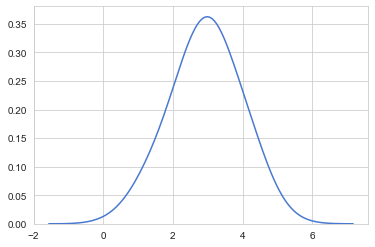

In [8]:
_params_list = [(3, 1), (3, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [9]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 2.9314403713954422
	Mean variance: 0.010092848033377073
	Variance mean: 0.9688629653973488
	Variance variance: 0.016918046045290205


##### Stratified proportionally

In [10]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 2.931784254129746
	Mean variance: 0.009485787977886783
	Variance mean: 0.965962697974105
	Variance variance: 0.017158747551849034
Estimation results
	Mean mean: 2.9116118478136093
	Mean variance: 0.3817512955965351
	Variance mean: 0.9340866998872596
	Variance variance: 0.9332995504872956


##### Stratified optimally

In [11]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 2.9270122512999213
	Mean variance: 0.01060679290011059
	Variance mean: 0.9677058337362807
	Variance variance: 0.01712245859127299
Estimation results
	Mean mean: 2.7781105972009175
	Mean variance: 0.3968491686911383
	Variance mean: 1.1168578411397934
	Variance variance: 1.0989196288132441


### Different means same vars

0.3×N(0, 1) + 0.5×N(10, 1) + 0.2×N(3, 1)
Population mean: 5.657574789450342
Population variance: 21.185506242006507


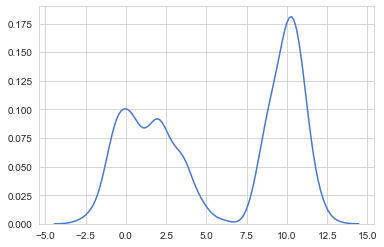

In [12]:
_params_list = [(0, 1), (10, 1), (3, 1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [13]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.6491144753384
	Mean variance: 0.20953677048099548
	Variance mean: 20.95077466123089
	Variance variance: 1.5529204981604163


##### Stratified proportionally

In [14]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.655709715359891
	Mean variance: 0.011022495380651984
	Variance mean: 21.159187364132027
	Variance variance: 0.8606925509722314
Estimation results
	Mean mean: 5.641767033768455
	Mean variance: 0.33934348434333733
	Variance mean: 21.226007858604955
	Variance variance: 0.877251674874991


##### Stratified optimally

In [15]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.6572180389485
	Mean variance: 0.010132613834279307
	Variance mean: 21.192319937454673
	Variance variance: 0.7643820615888597
Estimation results
	Mean mean: 5.703583255239629
	Mean variance: 0.3843772185842289
	Variance mean: 20.898299766976454
	Variance variance: 1.0702601861377057


### Different means and vars

0.3×N(0, 0.5) + 0.5×N(10, 1) + 0.2×N(3, 0.1)
Population mean: 5.597208990868954
Population variance: 21.09730408310543


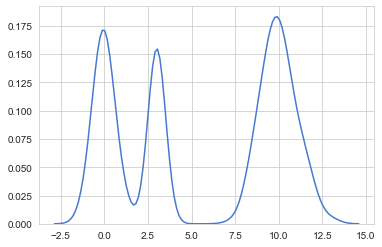

In [16]:
_params_list = [(0, .5), (10, 1), (3, .1)]
_rnorms = generate_rnorms(_N, _Ws, _params_list)

##### Simple random choice

In [17]:
print_modelling_and_estimation_results('simple', _iters, _n, _rnorms, _Ws, _params_list)

Choice: simple
Modelling results
	Mean mean: 5.573950704330126
	Mean variance: 0.19708860801528158
	Variance mean: 20.912074259877414
	Variance variance: 1.292251699039136


##### Stratified proportionally

In [18]:
print_modelling_and_estimation_results('stratify_prop', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_prop
Strat samples sizes: [30, 50, 20]
Modelling results
	Mean mean: 5.597477163625194
	Mean variance: 0.00631679420197981
	Variance mean: 21.08385593721991
	Variance variance: 0.5720388374166575
Estimation results
	Mean mean: 5.468045977556766
	Mean variance: 0.2713242425307275
	Variance mean: 21.344610964007515
	Variance variance: 0.5833457622105517


##### Stratified optimally

In [19]:
print_modelling_and_estimation_results('stratify_optimal', _iters, _n, _rnorms, _Ws, _params_list)

Choice: stratify_optimal
Strat samples sizes: [27, 64, 8]
Modelling results
	Mean mean: 6.708244718378912
	Mean variance: 0.007639275130987063
	Variance mean: 21.21558735550567
	Variance variance: 0.46635493720102544
Estimation results
	Mean mean: 5.522233983916407
	Mean variance: 0.24450216580357026
	Variance mean: 20.843560908020983
	Variance variance: 0.5151320024166838


### Conclusion

Based on modelling it is possible to conclude that stratified sampling indeed generally produces more representative results than simple random sampling does.